In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, models
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import numpy as np

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
posts (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     3200000     posts[0][0]                      
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 128)    41088       embedding[0][0]                  
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, None, 128)    0           conv1d[0][0]                     
_______________________________________________________________________________________

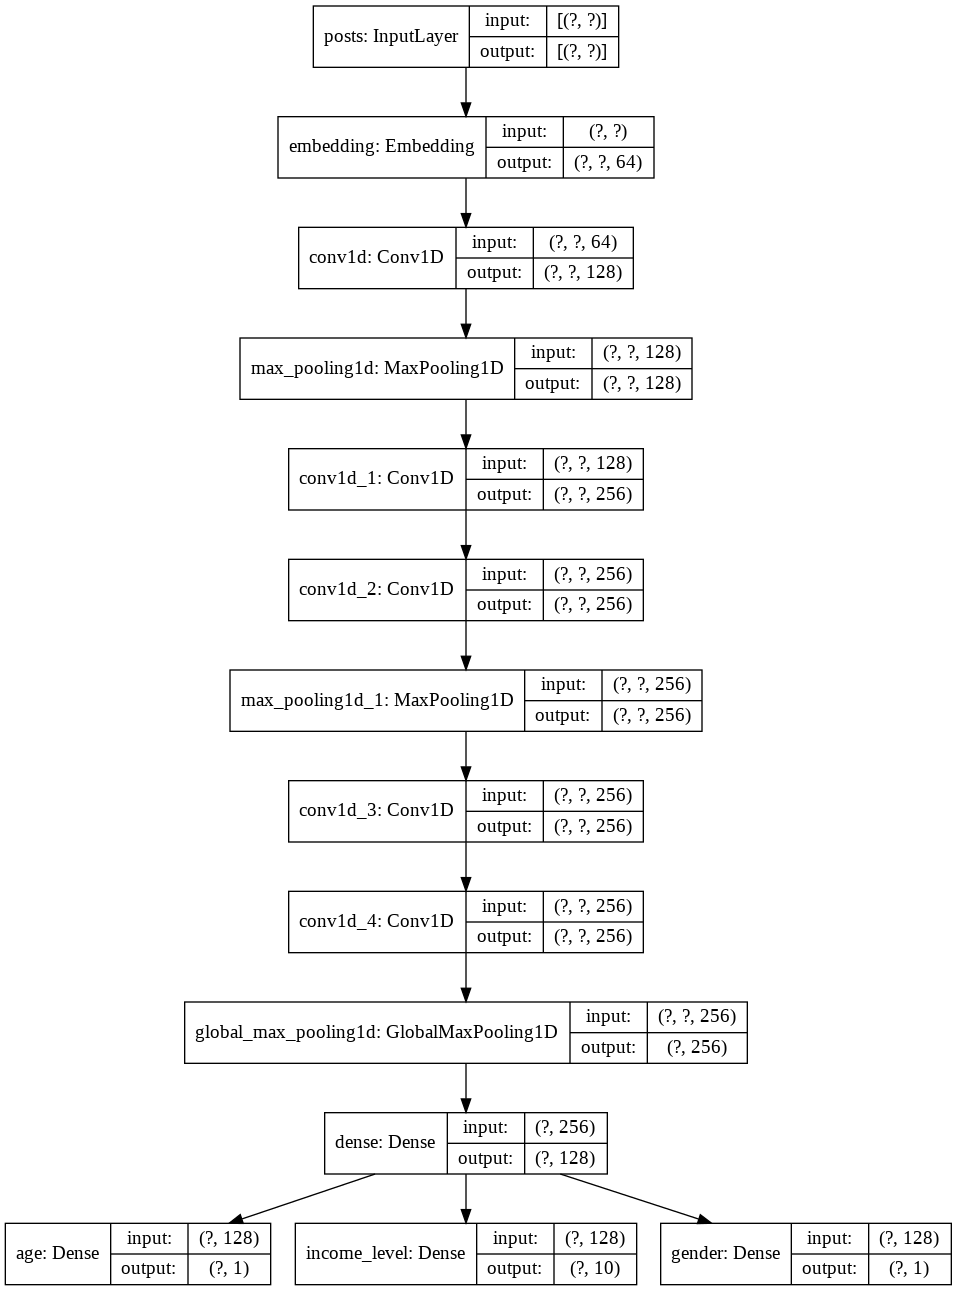

In [ ]:
# Let's try and create a model for a problem like above:
# Say that we get social media posts in order to predict
# the person's attributes like income level, age, gender etc.

# We'll need huge vocabulary in order to process 
# these posts
vocabulary_size = 50000
num_income_groups = 10 # say we have 10 different income level

# the posts are 1D text matrices.
posts_input = layers.Input((None,), name = 'posts')
embedded_posts = layers.Embedding(vocabulary_size, 64)(posts_input)
x = layers.Conv1D(128, 5, activation = 'relu')(embedded_posts)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation = 'relu')(x)  
x = layers.Conv1D(256, 5, activation = 'relu')(x)  
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation = 'relu')(x)  
x = layers.Conv1D(256, 5, activation = 'relu')(x)  
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation = 'relu')(x)
# now create the heads
age_prediction = layers.Dense(1, name = 'age')(x)
income_prediction = layers.Dense(num_income_groups,
                                 activation = 'softmax',
                                 name = 'income_level')(x)
gender_prediction = layers.Dense(1, activation = 'sigmoid',
                                 name = 'gender')(x)

model = models.Model(posts_input, [age_prediction,
                                   income_prediction,
                                   gender_prediction])
print(model.summary())
plot_model(model, show_shapes = True)

In [ ]:
# Since we'll have predictions for different tasks
# (regression, multi-label classification, binary classification)
# we have to use different losses for these in training process

# Gradient descent tries to minimize a scalar 
# so we should use single value as a losses.
# One way to proceed this is summing up the losses
# but if this loss contributions are very imbalanced,
# the model will be optimized preferentially for the task
# with the largest individual loss. 
# We can prevent this by using weighted sums of loss functions.
# In this example we have three tasks (1 regression, 2 classification)
# I'll use MSE, categorical and binary cross entropy as loss functions
# MSE will have an output 3-5 generally while 
# binary cross entropy can output something like 0.1
# So I'll scale them in order to prevent imbalanced sum

# model.compile(optimizer = 'rmsprop',
#               loss = ['mse', 'categorical_crossentropy', 'binary_crossentropy'],
#               loss_weights = [.25, 1., 10.])

# you can also specify losses with dictionaries (output layers must've names)

model.compile(optimizer = 'rmsprop',
              loss = {'age' : 'mse',
                      'income_level' : 'categorical_crossentropy',
                      'gender' : 'binary_crossentropy'},
              loss_weights = {'age' : 0.25,
                              'income_level' : 1.,
                              'gender' : 10.})

In [ ]:
# Now create synthetic data to training phase
num_samples = 100
posts = np.random.randint(1, vocabulary_size,
                          size = (num_samples, vocabulary_size))
age_targets = np.random.randint(1,80,
                                size = (num_samples,))
income_targets = np.zeros((num_samples, num_income_groups))
for row in income_targets:
  row[np.random.randint(0,len(row))] = 1

gender_targets = np.random.randint(0,1,
                                   size = (num_samples,))

# train the model
# r = model.fit(posts, [age_targets, income_targets, gender_targets],
#               epochs = 10, batch_size = 64)

r = model.fit(posts, {'age' : age_targets,
                      'income_level' : income_targets,
                      'gender' : gender_targets},
              epochs = 10,
              batch_size = 64)

Epoch 1/10
2/2 [==============================] - 25s 13s/step - loss: 532.8660 - age_loss: 2100.1833 - income_level_loss: 2.4880 - gender_loss: 0.5332
Epoch 2/10
2/2 [==============================] - 27s 14s/step - loss: 759.3522 - age_loss: 2971.5032 - income_level_loss: 15.8306 - gender_loss: 0.0646
Epoch 3/10
2/2 [==============================] - 25s 13s/step - loss: 415.7518 - age_loss: 1649.2866 - income_level_loss: 2.7818 - gender_loss: 0.0648
Epoch 4/10
2/2 [==============================] - 25s 13s/step - loss: 273.2744 - age_loss: 1076.8405 - income_level_loss: 4.0373 - gender_loss: 0.0027
Epoch 5/10
2/2 [==============================] - 25s 13s/step - loss: 134.3097 - age_loss: 511.7720 - income_level_loss: 6.3667 - gender_loss: 3.2369e-06
Epoch 6/10
2/2 [==============================] - 25s 13s/step - loss: 136.3073 - age_loss: 524.6641 - income_level_loss: 5.1412 - gender_loss: 3.3497e-06
Epoch 7/10
2/2 [==============================] - 25s 13s/step - loss: 143.3024 -